# 📘 PISA 2022 UK Data – Modeling Progress

## 🧪 Models Tried So Far

I have explored the use of **Decision Trees** and **Random Forests** on the PISA 2022 UK dataset:

- **Decision Tree:** Overfit the training data and performed poorly on validation.
- **Random Forest (Ensemble):** Helped reduce overfitting and improved generalization slightly.

---

## 🧪 Previous Modeling Summary

In earlier experiments (see separate notebook), Random Forests improved overfitting issues observed with a simple decision tree but offered only marginal gains in accuracy. The model performed moderately well but was limited by the binary nature of the target variable, which may have obscured more subtle variations in student performance.

---

## 🚀 Next Steps

I now plan to:

- Switch to a **continuous target variable** (`math_1`) instead of the binary `math_binary` to capture finer-grained student performance.
- Apply **Gradient Boosting** (specifically Gradient Boosted Trees) to model the continuous target.
- Investigate performance improvements using **regression metrics** (e.g., MAE, RMSE, R²).

---

## 🌱 What Is Gradient Boosting?

**Gradient Boosting** is a powerful ensemble method that builds a model in a **stage-wise fashion**, correcting errors made by previous models. Unlike **Random Forests**, which train trees independently in parallel (bagging), Gradient Boosting trains trees **sequentially**, with each tree attempting to minimize the residual errors from the previous one.

### 🔁 Key Comparison

| Method                         | Strategy                        | Trees Trained | Goal                            |
|--------------------------------|----------------------------------|---------------|---------------------------------|
| **Bagging** (e.g., Random Forest) | Parallel, on bootstrap samples   | Independently | Reduce variance                 |
| **Boosting** (e.g., Gradient Boosting) | Sequential, on residuals         | Step-by-step  | Reduce bias and overall error   |

In Gradient Boosting, the final prediction is a **weighted sum of all the weak learners** (typically shallow trees), with each tree focusing more on correcting the mistakes of its predecessors.

## 0. Import libraries, load and split data

In [1]:
#Import libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import shap

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load and split data 

In [4]:
train_df = pd.read_csv("/workspaces/mini_project_2/data/processed/train_cont.csv")
val_df   = pd.read_csv("/workspaces/mini_project_2/data/processed/val_cont.csv")
test_df  = pd.read_csv("/workspaces/mini_project_2/data/processed/test_cont.csv")

In [5]:
X_train = train_df.drop(columns=["target", "sample_weight"])
y_train = train_df["target"]
w_train = train_df["sample_weight"]

X_val = val_df.drop(columns=["target", "sample_weight"])
y_val = val_df["target"]
w_val = val_df["sample_weight"]

X_test = test_df.drop(columns=["target", "sample_weight"])
y_test = test_df["target"]
w_test = test_df["sample_weight"]

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)

print(y_train.shape, y_val.shape, y_test.shape)

(7782, 21) (2595, 21) (2595, 21)
(7782,) (2595,) (2595,)


In [7]:
list(X_train.columns)

['gender',
 'life_sat',
 'math_hwork',
 'SES',
 'num_sib',
 'food_sec',
 'family_stat',
 'has_computer',
 'has_books',
 'schl_belong',
 'teacher_help',
 'safe_student',
 'safe_class',
 'qual_math_instruct',
 'make_friends',
 'feel_included',
 'no_mock',
 'region_england',
 'region_n_ireland',
 'region_scotland',
 'region_wales']

# 1. Train a Baseline XGBoost Regressor

In [8]:
#initialise the model 
baseline = XGBRegressor(
    objective='reg:squarederror',  # Required for regression
    verbosity=0,
    random_state=42
)

In [9]:
#fit the model 
baseline.fit(X_train, y_train, sample_weight=w_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
#make predictions 
train_preds = baseline.predict(X_train)
val_preds = baseline.predict(X_val)

In [11]:
#calculate the RMSE for training and validation sets (RMSE is easeir to interpret than MSE becuase it is in the same untis as the target variable) 
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
val_rmse = sqrt(mean_squared_error(y_val, val_preds))

In [12]:
#calculate the R2 (coefficient of determination) for training and validation sets
train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)

In [13]:
#print the metrics 
print(f"Train RMSE: {train_rmse:.3f}, R²: {train_r2:.3f}")
print(f"Val RMSE: {val_rmse:.3f}, R²: {val_r2:.3f}")

Train RMSE: 56.675, R²: 0.643
Val RMSE: 88.783, R²: 0.143


#### Summary: The model performs moderately well on the training data (RMSE: 56.68, R²: 0.64) but generalizes poorly to the validation set (RMSE: 88.78, R²: 0.14), suggesting overfitting.Regularization or model tuning may help improve generalization.

# 2. Manual Tuning of hyperparameters 

## 2.1. Tune max_depth

In [23]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# Loop through different values of max_depth to compare model performance
for d in [2, 3, 4, 5, 6]:
    # initialise model
    model = XGBRegressor(
        max_depth=d,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )

    # fit the model to the training data with sample weights
    model.fit(X_train, y_train, sample_weight=w_train)

    # predict on both training and validation sets
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # calculate RMSE for both sets
    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_val, val_preds))

    # print RMSE results
    print(f"max_depth={d} | Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}")

max_depth=2 | Train RMSE: 78.437, Val RMSE: 82.666
max_depth=3 | Train RMSE: 75.743, Val RMSE: 83.922
max_depth=4 | Train RMSE: 71.750, Val RMSE: 86.182
max_depth=5 | Train RMSE: 65.218, Val RMSE: 86.877
max_depth=6 | Train RMSE: 56.675, Val RMSE: 88.783


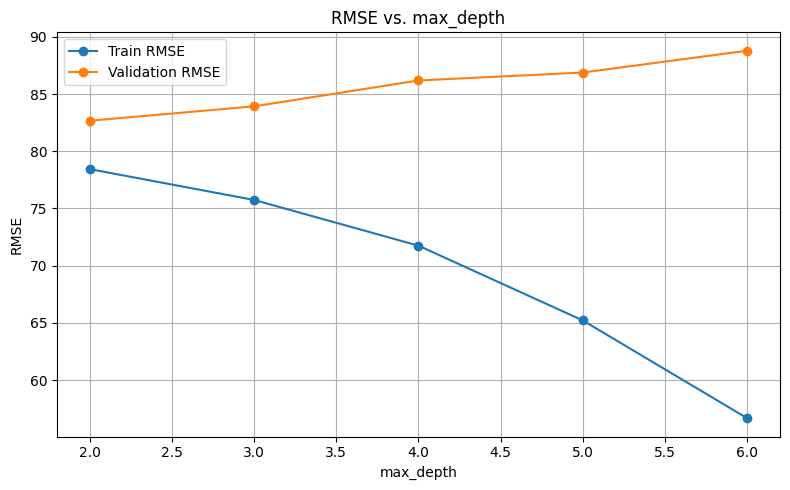

In [31]:
# visualise the results 
max_depths = [2, 3, 4, 5, 6]
train_rmse = [78.437, 75.743, 71.750, 65.218, 56.675]
val_rmse = [82.666, 83.922, 86.182, 86.877, 88.783]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(max_depths, train_rmse, marker='o', label='Train RMSE')
plt.plot(max_depths, val_rmse, marker='o', label='Validation RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('RMSE vs. max_depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Summary:
Increasing `max_depth` improves training performance but consistently worsens validation RMSE, indicating overfitting. The best generalization is achieved at `max_depth=2`, suggesting a shallow model is more effective for this dataset.

## 2.2. Tune reg_lamba

#### **`reg_lambda`** controls L2 regularization in XGBoost by penalizing large leaf weights, helping to reduce overfitting. Higher values encourage simpler models that generalize better, while lower values allow the model to fit the training data more closely.

In [26]:
for reg_lambda in [0, 0.1, 1, 10]:
    model = XGBRegressor(
        max_depth=2,
        n_estimators=100,
        reg_lambda=reg_lambda,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train, sample_weight=w_train)
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_val, val_preds))

    print(f"reg_lambda={reg_lambda} | Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}")

reg_lambda=0 | Train RMSE: 78.436, Val RMSE: 82.666
reg_lambda=0.1 | Train RMSE: 78.436, Val RMSE: 82.666
reg_lambda=1 | Train RMSE: 78.437, Val RMSE: 82.666
reg_lambda=10 | Train RMSE: 78.430, Val RMSE: 82.692


#### Tuning `reg_lambda` had minimal effect on RMSE for both training and validation sets, suggesting that L2 regularization is not significantly impacting model complexity at the current depth.

## 2.3. Tune n_estimators 

**🧠 What is `n_estimators`?**  
`n_estimators` controls the number of boosting rounds (i.e., the number of trees the model builds). Increasing it can improve training accuracy, but too many trees may lead to overfitting and poor generalization on validation data.


In [28]:
# Values to try
n_estimators_values = [50, 100, 200, 300, 500]

# Loop over different n_estimators
for n_estimators in n_estimators_values:
    
    # Initialize model with current n_estimators
    model = XGBRegressor(
        max_depth=3,
        n_estimators=n_estimators,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )
    
    # Fit the model
    model.fit(X_train, y_train, sample_weight=w_train)

    # Predict
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Evaluate
    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_val, val_preds))

    # Print results
    print(f"n_estimators={n_estimators} | Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}")


n_estimators=50 | Train RMSE: 77.492, Val RMSE: 83.249
n_estimators=100 | Train RMSE: 75.743, Val RMSE: 83.922
n_estimators=200 | Train RMSE: 73.979, Val RMSE: 85.192
n_estimators=300 | Train RMSE: 72.638, Val RMSE: 86.379
n_estimators=500 | Train RMSE: 70.385, Val RMSE: 88.318


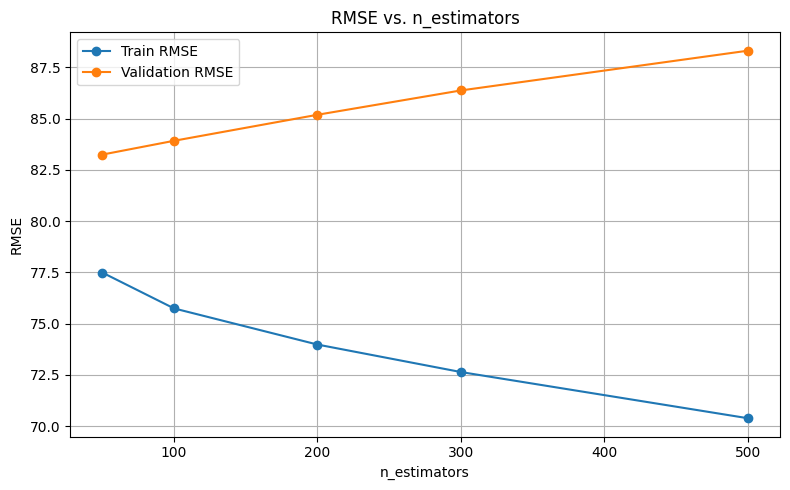

In [30]:
# Your tuning results
n_estimators = [50, 100, 200, 300, 500]
train_rmse = [77.492, 75.743, 73.979, 72.638, 70.385]
val_rmse = [83.249, 83.922, 85.192, 86.379, 88.318]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(n_estimators, train_rmse, marker='o', label='Train RMSE')
plt.plot(n_estimators, val_rmse, marker='o', label='Validation RMSE')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs. n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Values to try
n_estimators_values = [40, 60, 75]

# Loop over different n_estimators
for n_estimators in n_estimators_values:
    
    # Initialize model with current n_estimators
    model = XGBRegressor(
        max_depth=3,
        n_estimators=n_estimators,
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )
    
    # Fit the model
    model.fit(X_train, y_train, sample_weight=w_train)

    # Predict
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Evaluate
    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_val, val_preds))

    # Print results
    print(f"n_estimators={n_estimators} | Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}")


n_estimators=40 | Train RMSE: 78.014, Val RMSE: 83.227
n_estimators=60 | Train RMSE: 77.061, Val RMSE: 83.367
n_estimators=75 | Train RMSE: 76.422, Val RMSE: 83.546


##### Fine-tuning `n_estimators` around the initial optimum confirmed that 40 trees yields the best validation performance (RMSE: 83.227). Increasing the number of trees beyond this point led to consistent overfitting without improving generalization.

## 2.3. Tune learning_rate

Tuning the learning rate is a critical step as it controls how much each new tree contributes to the overall model - a smaller learning rate means the model learns more gradually, which can improve generalisation but requires more trees to converge, whereas a larger learning_rate speeds up learning, but increases the risk of overfitting. 

In [40]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35]
train_rmse_list = []
val_rmse_list = []

for lr in learning_rates:
    model = XGBRegressor(
        learning_rate=lr,
        n_estimators=40,            # Fixed for now (you can fine-tune later)
        max_depth=2,                 # Keep consistent for fair comparison
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    )
    
    model.fit(X_train, y_train, sample_weight=w_train)
    
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = sqrt(mean_squared_error(y_val, val_preds))
    
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
    
    print(f"learning_rate={lr} | Train RMSE: {train_rmse:.3f}, Val RMSE: {val_rmse:.3f}")

learning_rate=0.001 | Train RMSE: 94.652, Val RMSE: 95.728
learning_rate=0.01 | Train RMSE: 91.702, Val RMSE: 92.961
learning_rate=0.05 | Train RMSE: 85.996, Val RMSE: 87.458
learning_rate=0.1 | Train RMSE: 83.186, Val RMSE: 84.900
learning_rate=0.2 | Train RMSE: 80.686, Val RMSE: 83.078
learning_rate=0.25 | Train RMSE: 80.066, Val RMSE: 82.760
learning_rate=0.3 | Train RMSE: 79.777, Val RMSE: 82.761
learning_rate=0.35 | Train RMSE: 79.658, Val RMSE: 82.819


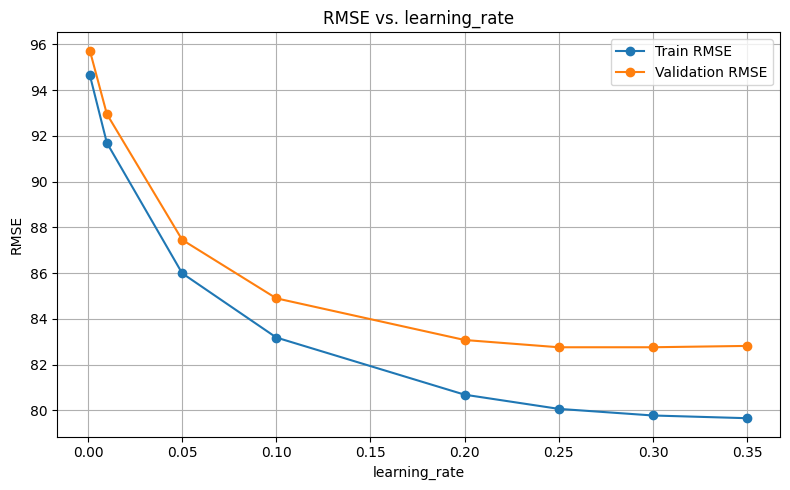

In [41]:
# plot the results 
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, train_rmse_list, marker='o', label='Train RMSE')
plt.plot(learning_rates, val_rmse_list, marker='o', label='Validation RMSE')
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.title('RMSE vs. learning_rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As the `learning_rate` increased from 0.001 to 0.25, both training and validation RMSE steadily decreased, indicating improved model performance. The lowest validation RMSE was observed at `learning_rate=0.25`, with minimal gains beyond that and slight signs of overfitting as the rate increased further.